# Multivariate Poisson Lognormal (MPLN) model
The MPLN model (?) relates some $p$-dimensional observation vectors $\boldsymbol{Y}_i$ to some $p$-dimensional vectors of Gaussian latent variables $Z_i$ as follows
$$
\begin{aligned}
& \boldsymbol{Y}_i\left|\boldsymbol{Z}_i \sim \operatorname{Poisson}\left(e^{Z_i}\right), \quad Y_{i j}\right| Z_{i j} \text { indep. } \\
& Z_i \sim \mathcal{N}\left(\boldsymbol{X}_i^{\top} \boldsymbol{B}_{d \times p}, \Sigma_{p \times p}\right)
\end{aligned}
$$
where
- $Y_{i j}$ represents the $j$ th code of $i$ th patient with $i=1, \cdots, n$ and $j=1, \cdots, p, \boldsymbol{Y}=\left(\boldsymbol{Y}_1, \cdots, \boldsymbol{Y}_n\right)^{\top} \in$ $\operatorname{Rn}^n \times p$
- $Z_i$ is the patient-level embedding of ith patient, $Z=\left(Z_1, \cdots, Z_n\right)^{\top} \in \mathbb{R}^{n \times p}$,
- $\boldsymbol{X}_i$ is the covariates of ith patient, $\boldsymbol{X}=\left(\boldsymbol{X}_1, \cdots, \boldsymbol{X}_n\right)^{\top} \in \mathbb{R}^{n \times d}$
## Leveraging external information for $\Sigma$
In the MPLN model, $\boldsymbol{\Sigma}$ describes the underlying residual relationships between the $p$ codes. We may decompose $\boldsymbol{\Sigma}=\boldsymbol{V} \boldsymbol{\Lambda} \boldsymbol{V}^{\top}$, where $\boldsymbol{V} \in \mathbb{R}^{p \times q}$ is orthonormal and the rank $q \leq p, \boldsymbol{\Lambda} \in \mathbb{R}^{q \times q}$ is diagonal. Assuming that across different institution/dataset, the orientation/rotation $(\boldsymbol{V})$ is the same but the shape/scaling $\boldsymbol{\Lambda}$ can be different, we may borrow $\boldsymbol{V}$ that is obtained from external sources for model estimation. In that case, instead of estimating the full covariance matrix $\mathbf{\Sigma}$, we only need to estimate the diagnol matrix $\boldsymbol{\Lambda}$.
An alternative way to write the model:
$$
\begin{aligned}
& \boldsymbol{Y}_i\left|\boldsymbol{Z}_i \sim \operatorname{Poisson}\left(e^{Z_i}\right) \quad, \quad Y_{i j}\right| Z_{i j} \text { indep. } \\
& \boldsymbol{Z}_i={\color{red}\boldsymbol{B}^\top\boldsymbol{X}_i + \boldsymbol{V} \boldsymbol{\Lambda}^{1 / 2}  \boldsymbol{W}_i } \quad, \\
& \boldsymbol{W}_i \sim \mathcal{N}\left(0_q, \boldsymbol{I}_{q \times q}\right) \quad \text { iid }
\end{aligned}
$$

## Joint likelihood
In matrix notation, $\boldsymbol{Z}=\boldsymbol{X} \boldsymbol{B}+\boldsymbol{W} \boldsymbol{\Lambda}^{1 / 2} \boldsymbol{V}^{\top}$. The observation matrix $\boldsymbol{Y}$ only depends on $\boldsymbol{Z}$ through $\boldsymbol{B}, \boldsymbol{\Lambda}$ and $\boldsymbol{W}$, and the complete log-likelihood is therefore
$$
\begin{aligned}
\log p(\boldsymbol{Y}, \boldsymbol{W} ; \boldsymbol{B}, \boldsymbol{\Lambda})= & \sum_{i=1}^n \log p\left(\boldsymbol{Y}_i \mid \boldsymbol{W}_i ; \boldsymbol{B}, \boldsymbol{\Lambda}\right)+\log p\left(\boldsymbol{W}_i\right) \\
= & \mathbf{1}_n^{\top}\left\{\boldsymbol{Y} \odot\left(\boldsymbol{X} \boldsymbol{B}+\boldsymbol{W} \boldsymbol{\Lambda}^{1 / 2} \boldsymbol{V}^{\top}\right)-\exp \left(\boldsymbol{X} \boldsymbol{B}+\boldsymbol{W} \boldsymbol{\Lambda}^{1 / 2} \boldsymbol{V}^{\top}\right)\right\} \mathbf{1}_p \\
& -\frac{\|\boldsymbol{W}\|_F^2}{2}-\frac{n q}{2} \log (2 \pi)-\mathbf{1}_n^{\top} \log (\boldsymbol{Y} !) \mathbf{1}_p
\end{aligned}
$$

## Computing the MAP for W_i
The estimate for $W_i$ is the maximizer of the above joint loglihood. It is also called the maximum a posteriori (the MAP). By observational independence each $W_i$ can be computed individually. What's more, by conditional independence (on W_i), the joint log-likelihood for $(Y_i, W_i)$ is

$$
\log p(Y_i, W_i; B, A) = \sum_{j=1}^p \log p(y_{ij}|W_i;B, A) + \log p(W_i) 
$$

With derivative with respect to $W_i$ :

$$
\nabla_{W_i} = \frac{\partial }{\partial W_i}\log p(Y_i, W_i ; \boldsymbol{B}, \boldsymbol{\Lambda}) =\\ \sum_{j=1}^p A^{1/2} V_j (y_{ij} - \exp(x_{i}^\top\beta_j + W_i^\top A^{1/2}V_j)) - W_i
$$

in matrix notations:

$$
\nabla_{W_i} =   A^{1/2} V^\top(Y_i - \exp(B^\top x_i + V A^{1/2} W_i )) - W_i
$$

Here the role of "covariates" are taken by $VA^{1/2}$ and that of  "parameters" by the $W_i$, with a l2-norm penalty in the $W_i$.

The hessian is

$$
\nabla^2_{W_i} = - (A^{1/2} V^\top \text{diag}(\exp(B^\top x_i + V A^{1/2} W_i )) V A^{1/2} + I_q)
$$

Solving for $W_i$ can be done by Newton method: starting at some value $W_i^{(t)}$, the next iterate is given by


$$
W_i^{(t+1)} = W_i^{(t)} - [\nabla^2_{W_i}]^{-1} \nabla_{W_i}, 
$$

alternatively, IRLS could be used. Now, this needs to be done for every $W_i$. In our current implementation, we loop over all $W_i$. For optimal it should be vectorized. For instance, instead of computing a hessian matrix for all $i$, we can get its diagonal elements instead, and approximate the hessian by a diagonal matrix, yielding a quasi-newton method. These matrices are easy to obtain, specifically, the diagonal element $[\nabla^2_{W_i}]_{kk}$ is obtained as


$$
[\nabla^2_{W_i}]_{kk} = (A^{1/2} V_{\cdot k} \odot \mu_i ) ^\top A^{1/2} V_{\cdot k} \odot \mu_i  
$$

where $\mu_i = \exp(B^\top x_i + V A^{1/2} W_i ) $. The diagonal can be computed at once as 

(A1/2 V) *mu_i**2.sum(dim=0)

We could now use tensors to compute all diagonal elements at once
However, for simplicity we do not do that now.



```python
diag_elements = 
```


This is easly computable for all $i$ simultaneously by




 Specifically, for each updating step, we need to compute $n$ hessian matrices.  



## 2.4 Simulation setting
Let $n=5000, p=50$. Consider two scenarios: true covariance has full rank and has low rank.
- Scenario 1 (true covariance with full rank):
1. Generate $\boldsymbol{\Sigma}=A R_1(0.8)$. Find its eigen-decomposition $\boldsymbol{\Sigma}=\boldsymbol{V} \boldsymbol{\Lambda} \boldsymbol{V}^{\top}$. 
2. Generate $\boldsymbol{Z} \sim \mathcal{N}(\mathbf{0}, \boldsymbol{\Sigma})$ and $\boldsymbol{Y} \sim \operatorname{Poisson}\left(e^{\boldsymbol{Z}}\right)$.
3. Fit model with $\boldsymbol{V}$,

    a. (correct) assuming $\boldsymbol{\Sigma}$ has full rank, $\boldsymbol{\Lambda} \in \mathbb{R}^{p \times p}$, we use the full $\boldsymbol{V}$ here.
    
    b. (low rank appriximation) assuming $\boldsymbol{\Sigma}$ has lower rank, $\Lambda \in \mathbb{R}^{q \times q}$ with $q=20,10,5$, we only use $\boldsymbol{V}_{[, 1: q]}$ here.

- Scenario 2 (true covariance with low rank, $q=12$ ):
1. Generate $\boldsymbol{\Sigma}=A R_1(0.8)$. Find its eigen-decomposition $\boldsymbol{\Sigma}=\boldsymbol{V} \boldsymbol{\Lambda} \boldsymbol{V}^{\top}$.
2. Let $\tilde{\boldsymbol{\Sigma}}=\boldsymbol{V}_{[, 1: q]} \boldsymbol{\Lambda}_{[1: q, 1: q]} \boldsymbol{V}_{[, 1: q]}^T$. Find its eigen-decomposition $\tilde{\mathbf{\Sigma}}=\tilde{\boldsymbol{V}} \tilde{\boldsymbol{\Lambda}}^{\top}$. This will be our true covariance with known rank $=q$. (In reality we observe $\bar{\Sigma}$ from external sources)
4. Fit model with $\vec{V}$.
a. (neglecting low-rankness) assuming $\Sigma$ has full rank, $\Lambda \in \mathbb{R}^{p \times p}$, we use the full $\tilde{V}$ here.
b. (correct) assuming $\Sigma$ has lower rank, $\Lambda \in \mathbb{R}^{q \times q}$ with $q=20,10,5$, we only use $\tilde{\boldsymbol{V}}_{[, 1: q]}$. here. (In reality we don't know the true rank, so would also need to implement a procedure to select for the best $q$.

## Some notes on implementation
* The $q\times q$ matrix $A$ is diagonal and its vector of diagonal elements $a$ must be strictly positive. This constraint identifies the model. To implement this constraint, at every iteration, if $a_j$ is negative , we multiply wlog both $a_j$ and the $j$ th latent variable $z_j$ by $-1$.

In [922]:
import numpy as np
import torch
from torch.nn.utils import clip_grad_value_
from torch import nn
from sklearn.linear_model import PoissonRegressor

def gen_Sigma(num_features, rho=0.8):
    # AR1 parameters

    # Generate AR1 covariance matrix
    cov_matrix = rho ** np.abs(np.subtract.outer(np.arange(num_features), np.arange(num_features)))

    # Perform eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    sort_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sort_indices]
    eigenvectors = eigenvectors[:, sort_indices]

    # Calculate V and A
    V = eigenvectors
    a = eigenvalues


    return cov_matrix, V, a

def gen_X(n, num_covariates, intercept=True):
    X = torch.randn((n, num_covariates))
    if intercept and num_covariates > 0:
        X[:,0] = 0
    return X


In [923]:
class MPLN(nn.Module):
    def __init__(self, num_latents, num_features, num_covariates, V, A = None):
        super().__init__()
        self.num_latents = num_latents
        self.num_features = num_features
        self.num_covariates = num_covariates
        self.V = torch.tensor(V).float()
        self.encoder = Encoder(num_features, num_covariates, num_latents, num_hidden=100)

        # Initialize parameters
        self.B = nn.Parameter(torch.zeros((num_features, num_covariates)))
        self.a = nn.Parameter(torch.Tensor(A)) if A is not None else nn.Parameter(torch.ones(num_latents))

        # Initialize solver for W
        # Create Poisson regression model with L2 regularization
        self.poissonSolver =  PoissonRegressor(alpha=1/(num_features), fit_intercept=True) # TODO: check this intercept
    
    def forward(self, W, X=None, invlink=torch.exp):
        if X is None:
            X = torch.zeros((W.shape[0], 0))
        # Get the linpar (Z above) from the eigendecomposition
        VA = self.V * torch.sqrt(torch.exp(self.a.unsqueeze(0))) # TODO: a is in fact log_a
        linpar = X @ self.B.T + W @ VA.T
        condmean = linpar if invlink is None else invlink(linpar)
        return linpar, condmean

    def sample(self, n, X=None, poisson=True):
        with torch.no_grad():
            W = torch.randn((n, self.num_latents))

            if poisson is True:
                _, condmean = self(W, X, invlink=torch.exp)
                Y = torch.poisson(condmean).float()
            else:
                _, Y = self(W, X)

        return {'W': W, 'Y':Y}

    
    def estimate_W(self, Y, verbose=False):
        # Note: Since the TweedieRegressor's default penalty is L2, you just need to set alpha (which is equivalent to lambda in your case)
        with torch.no_grad():
            VA = self.V * torch.sqrt(torch.exp(self.a.unsqueeze(0))).detach().numpy()
        results = []
        Y = Y.numpy()
        for i in range(Y.shape[0]):
            if verbose:
                print(f'Computing latent variable : {i} / {Y.shape[0]}')
            self.poissonSolver.fit(VA, Y[i])
            results.append(self.poissonSolver.coef_)

        W = torch.Tensor(np.vstack(results))

        return W

class Encoder(nn.Module):
    def __init__(self, num_features, num_covariates, num_latents, num_hidden):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(num_features + num_covariates, num_hidden),
            # nn.Dropout(0.8),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            # nn.Dropout(0.8),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
    
    def forward(self, X, Y):
        # contaenate X and Y 
        XY = torch.cat((X, Y), dim=1)
        return self.fc(XY)

def train_encoder(X, Y, Z, model, optimizer, criterion, num_epochs=100,validation_data=None, verbose=True, random=False, sample=False, **kwargs):
    """
    Train a PyTorch model and return the model and the history of losses.

    :param x: The input data for model
    :param y: The labels for input data
    :param z: additional input data
    :param u: additional input data
    :param model: PyTorch model to train
    :param optimizer: Optimizer to use in training
    :param criterion: Loss function to use in training
    :param num_epochs: Number of training epochs. Default is 100.
    :param validation_data: Tuple of validation data (x_val, y_val, z_val, u_val). Default is None.
    :return: Tuple of trained model and history of losses.
    """
    # Switch model to training mode
    model.train()
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        if sample:
            with torch.no_grad():
                data = model.sample(Y.shape[0], X)
                Y = data['Y']
                Z = data['W']

        optimizer.zero_grad()

        # Forward pass
        outputs_z = model.encoder(X, Y)

        loss = criterion(outputs_z, Z)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if validation_data is not None:
            model.eval() # switch model to evaluation mode
            with torch.no_grad():
                z_val, y_val  = validation_data.values()
                val_z = model.encoder(X, y_val)
                val_loss =  criterion(val_z, z_val)
                val_losses.append(val_loss.item())
            model.train() # switch model back to training mode

        if verbose and (epoch % 10) == 0:
            print(f'Epoch: {epoch}, Training Loss: {loss.item()}, Val loss = {None if validation_data is None else val_loss}')

    return model, train_losses, val_losses

def train_model(model, data, A_init = None, num_epochs=1000, transform=False, verbose=False):
    if A_init is not None:
        model.a = torch.nn.Parameter(model_true.a.clone()) # Start at the solution for simulations.... a bit cheating but not too much

    criterion =  MELoss()
    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=1.0)

    # Define learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)


    encoder_optimizer = torch.optim.Adam(model.encoder.parameters(), lr=0.01)
    encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=10, gamma=0.99)
    encoder_criterion = nn.MSELoss()


    # Store the value of model.a at each epoch
    a_values = []

    # Training loop

    for epoch in range(num_epochs):
        _, encoder_loss, _ = train_encoder(X, data['Y'], data['W'], model=model, optimizer=encoder_optimizer, criterion=encoder_criterion, num_epochs=5, validation_data=None, sample=True, verbose=False)

        optimizer.zero_grad()
        
        with torch.no_grad():
            # # simulate
            data_sim = model.sample(n)
            # # train encoder

            # compute W and W_sim
            W = model.encoder(X, data['Y'])
            W_sim = model.encoder(X, data_sim['Y'])

            # W = model.estimate_W(data['Y'])
            # W_sim = model.estimate_W(data_sim['Y'])
        
        linpar, _ = model(W)
        linpar_sim, _ = model(W_sim)

        loss = criterion(data['Y'], linpar, data_sim['Y'], linpar_sim, transform=transform)
        
        loss.backward()
        clip_grad_value_(model.parameters(), clip_value=0.2)
        optimizer.step()
        

        # Update the schedulers
        scheduler.step()
        encoder_scheduler.step()
        
        # Store the value of model.a
        a = model.a.clone().detach().cpu().numpy()
        a_values.append(a)

        if verbose: 
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, model.a[:5]: {a[:5]}, Encoder loss: {encoder_loss[-1]}')
        
    aa = np.vstack(a_values)

    A_hist = aa[np.linspace(0, aa.shape[0]-1, max(aa.shape[0], 100), dtype=int)]
    A_last = aa[-100:]

    results = {
        'A' : model.a.detach().numpy(),
        'A_hist' : A_hist,
        'A_last': A_last
    }
    return results

class MELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y, linpar, ys, linpars, mask=None, transform=True):
        """Computes the loss. hat is recontructed y, ys is simulated"""

        if transform:
            with torch.no_grad():
                y_transformed =  torch.log(y.clone() + 1) 
                ys_transformed = torch.log(ys.clone() + 1)

            loss = -torch.sum(y_transformed* linpar - ys_transformed * linpars) / y.shape[0]

        else:
             loss = -torch.sum(y * linpar - ys * linpars) / y.shape[0] 
        return loss



In [924]:

# generate data
# -------------
n = 1000
num_features = 50
num_covariates = 0
num_latents = 50

Sigma, V, A = gen_Sigma(num_features, rho=0.8)
model_true = MPLN(num_latents, num_features, num_covariates, V[:,:num_latents], np.log(A[:num_latents]))
X = gen_X(n, num_covariates, intercept=True)
data = model_true.sample(n, X, poisson=True)

model = MPLN(num_latents, num_features, num_covariates, V[:,:num_latents])

# Training loop

In [928]:
fit = train_model(model, data, A_init = model_true.a.detach(), verbose=True, num_epochs=1000)


Epoch [1/1000], Loss: -9.090581893920898, model.a[:5]: [2.3417792 2.0766187 1.9712957 1.6636075 1.4660262], Encoder loss: 0.8441318869590759
Epoch [2/1000], Loss: 6.442722797393799, model.a[:5]: [2.1417792 1.8766186 1.7712957 1.4636074 1.2660261], Encoder loss: 0.7959972023963928
Epoch [3/1000], Loss: -10.614319801330566, model.a[:5]: [2.3417792 2.0766187 1.9712957 1.5390295 1.4660262], Encoder loss: 0.7638790607452393
Epoch [4/1000], Loss: 5.635312080383301, model.a[:5]: [2.1417792 1.8766186 1.7712957 1.3390294 1.2660261], Encoder loss: 0.7382186651229858
Epoch [5/1000], Loss: -7.624783515930176, model.a[:5]: [2.3417792 2.0766187 1.9712957 1.5390295 1.4660262], Encoder loss: 0.7278777956962585
Epoch [6/1000], Loss: 2.1462013721466064, model.a[:5]: [2.5417793 2.0320754 1.7712957 1.6921989 1.2660261], Encoder loss: 0.724605917930603
Epoch [7/1000], Loss: 8.2921724319458, model.a[:5]: [2.3417792 2.099093  1.5712956 1.4921988 1.4660262], Encoder loss: 0.7166789174079895
Epoch [8/1000], Lo

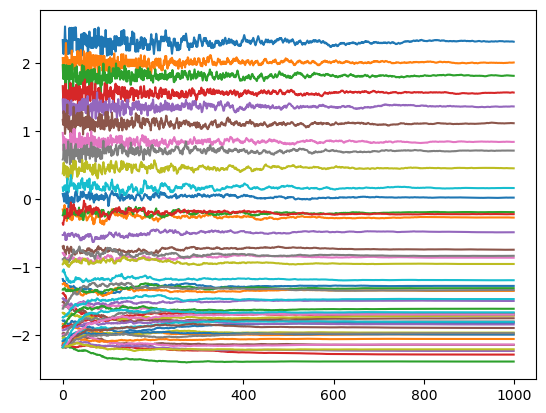

In [929]:
plt.plot(fit['A_hist'])

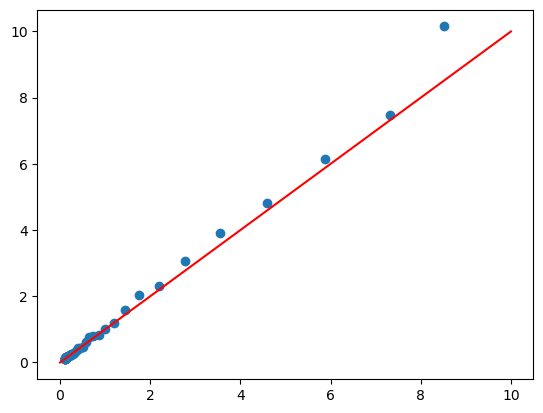

In [930]:
plt.scatter(torch.exp(model_true.a).detach().numpy(), torch.exp(model.a).sort(descending=True)[0].detach().numpy())
plt.plot([0,10], [0, 10], color="red")

In [944]:
import matplotlib.pyplot as plt

dat_sample = model.sample(n)
what = model.encoder(X, dat_sample['Y']).detach().numpy()
what_MAP = model.estimate_W(dat_sample['Y']).detach().numpy()
w_true = dat_sample['W'].detach().numpy()


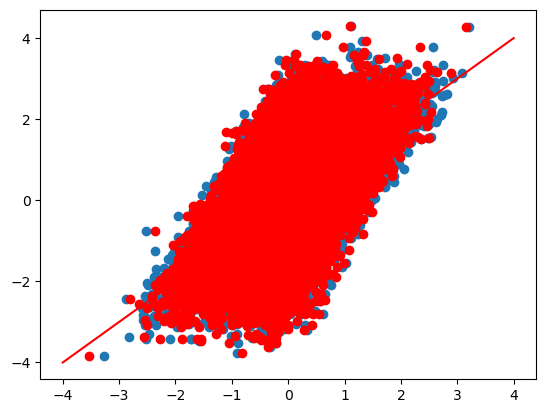

In [945]:
plt.scatter(what, w_true)
plt.scatter(what_MAP, w_true, color="red")
plt.plot([-4,4], [-4,4], color="red")

In [954]:
mse_MAP = np.mean((what_MAP-w_true)**2)
mse_ENC = np.mean((what-w_true)**2)

print(f'mse_MAP: {mse_MAP}, mse_ENC:{mse_ENC}')

mse_MAP: 0.6862107515335083, mse_ENC:0.6786494255065918


In [935]:
from pathlib import Path

path_folder = Path("sims/")
sim_number = 1
sim_name = "test"
file_name = f'model_state_dict_{sim_name}_{sim_number}.pth'
path_folder.mkdir(parents=True, exist_ok=True)

path_file = path_folder / file_name

torch.save(model.state_dict(), path_file)


In [936]:
# try loading
model = MPLN(num_latents, num_features, num_covariates, V[:,:num_latents], np.log(A[:num_latents]))
model.load_state_dict(torch.load(path_file))

<All keys matched successfully>

In [937]:
torch.save(model, 'sims/model2.pth')

In [938]:
model = torch.load('sims/model2.pth')

In [942]:
model(data['W'], X)

model.encoder(data['W'])

(tensor([[ 0.9280,  0.9541, -0.0871,  ...,  0.9895,  1.5249,  0.6411],
         [-0.2745,  0.2638,  0.1731,  ..., -0.8621,  0.0840,  0.4105],
         [ 1.3589,  1.9414,  0.8005,  ..., -0.7662, -0.9049, -0.2593],
         ...,
         [ 0.2133,  1.0894, -0.1138,  ...,  0.1301,  0.7312,  1.6789],
         [-0.1658, -0.1600,  0.3269,  ..., -1.1675, -1.4346, -1.6214],
         [-0.0319, -0.8236, -0.1487,  ...,  0.1946,  0.4161,  1.0784]],
        grad_fn=<AddBackward0>),
 tensor([[2.5295, 2.5962, 0.9166,  ..., 2.6899, 4.5948, 1.8986],
         [0.7599, 1.3018, 1.1890,  ..., 0.4223, 1.0877, 1.5076],
         [3.8920, 6.9683, 2.2266,  ..., 0.4648, 0.4046, 0.7716],
         ...,
         [1.2378, 2.9725, 0.8925,  ..., 1.1389, 2.0775, 5.3599],
         [0.8472, 0.8521, 1.3867,  ..., 0.3112, 0.2382, 0.1976],
         [0.9686, 0.4388, 0.8618,  ..., 1.2148, 1.5160, 2.9401]],
        grad_fn=<ExpBackward0>))